In [17]:
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('INFO')

np.random.seed(0)

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, TimeDistributed

# TF RNN

In [19]:
# data
# two input vectors = two timesteps
x = np.array([[[2,2], [3,3]]])

# input/output shape
inputs = Input((2,2)) # just one timestep
outputs = 2

# MODEL
output, state = SimpleRNN(outputs, return_state=True, activation='relu')(inputs)
model = Model(inputs=inputs, outputs=[output, state])

# print output and state
output, state = model.predict(x)
print('output: ', output)
print('state: ', state)
print('~~~~~~~~~~~~~~')
print('weights: ', model.get_weights())

output:  [[0.26372457 2.5810895 ]]
state:  [[0.26372457 2.5810895 ]]
~~~~~~~~~~~~~~
weights:  [array([[-1.0481719 , -0.01463342],
       [ 1.1329073 ,  0.528082  ]], dtype=float32), array([[ 0.9881021 ,  0.1537993 ],
       [-0.1537993 ,  0.98810214]], dtype=float32), array([0., 0.], dtype=float32)]


In [3]:
model.weights[1].value()

<tf.Tensor 'ReadVariableOp:0' shape=(2, 2) dtype=float32>

### weights[0] is the input matrix [input_dim, output_dim]
### weights[1] is the recurent matrix [output_dim, output_dim]
### weights[2] is the bias matrix [output_dim]

In [4]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 2)]            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       [(None, 2), (None, 2)]    10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
None


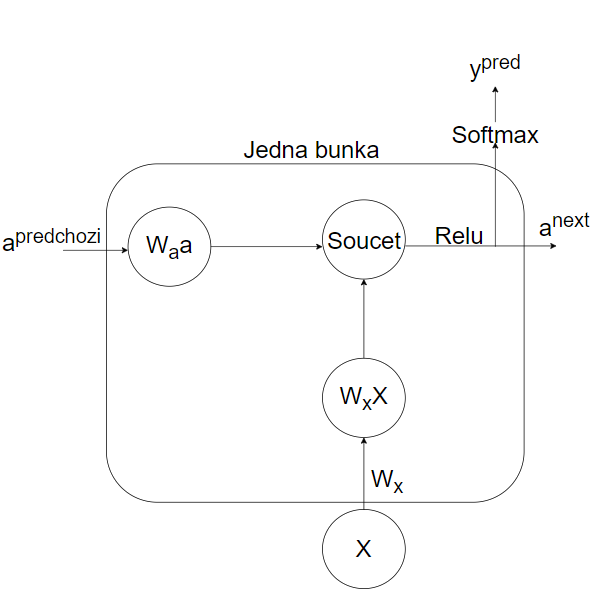

In [5]:
from IPython.display import Image
Image("rnn_cell.png")

# Numpy implementace

In [6]:
def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / ex.sum(axis=0)
def relu(x):
    return np.maximum(x, 0)
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [14]:
epochs = 20000

In [16]:
X = np.array([[0,0,0,1],[0,0,1,1],[0,1,1,1], [1,1,1,1]])
y = np.array([[0],[1],[2],[3]])

lr = 0.001

# lets try random weight that is just one shared number
Wx = np.random.randn()
Wa = np.random.randn()

state = np.zeros((X.shape[0],X.shape[1] + 1)) # has to be one column wider because of the State zero
gradient = np.zeros((X.shape))
states_in = np.zeros((X.shape[0],X.shape[1]))
states_out = np.zeros((X.shape[0],X.shape[1]))

# A training loop
for i in range(epochs): 
    # A propagation of input and recurrency through the cells 
    for j in range(X.shape[1]-1):
        states_in[j] = state[:,j]*Wa + X[:,j]*Wx
        states_out[j] = sigmoid(states_in[j])
        state[:,j+1] = states_out[j]
    
    # output from the net
    states_in[j+1]  = state[:,j+1]*Wa + X[:,j+1]*Wx
    state[:,j+2] = states_in[j+1]     
    
    # cost function is MSE
    loss = np.square(state[:,j+2] - np.squeeze(y)).sum() / len(x)
    
    # let's print output every n-th epoch
    if i % 4000 == 0:
        print( i, " epoch", "loss: ", loss) 
     
    # time for backprop
    grad_Wx = 0
    grad_Wa = 0
    gradient[:,vec_end-1] = (state[:,vec_end] - np.squeeze(y)) * (2/X.shape[1])

    # propagate the error through every cell in reverse order
    for i in range(X.shape[1]-1, 0, -1):        
        grad_Wx += gradient[:,i]*X[:,i-1]
        grad_Wa += gradient[:,i]*state[:,i-1]
        gradient[:,i-1] = gradient[:,i] * Wa  * relu(states_in[i])

    # update the shared weight
    Wx = Wx - lr * grad_Wx
    Wa = Wa - lr * grad_Wa

# make a prediction
for j in range(x.shape[1]-1):
    states_in[j] = state[:,j]*Wa + X[:,j]*Wx
    states_out[j] = sigmoid(states_in[j])
    state[:,j+1] = states_out[j]

    
states_in[j+1]  = state[:,j+1]*Wa + X[:,j+1]*Wx
state[:,j+2] = states_in[j+1]
     
print("y hat: ",np.round(states_in[j+1]))
print("true : ",y.T) 

0  epoch loss:  5.094590652078127
4000  epoch loss:  0.1186453592454508
8000  epoch loss:  0.03458781187256001
12000  epoch loss:  0.012676807364435038
16000  epoch loss:  0.005093823554751602
y hat:  [0. 1. 2. 3.]
true :  [[0 1 2 3]]
